In [79]:
!pip install tensorflow-addons


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [159]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP (ULTRA OPTIMIZED)
# ============================================================================
import os
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Input, Concatenate, 
    Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
)
from tensorflow.keras.optimizers import Adam

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [161]:
# ============================================================================
# SECTION 2: CONFIGURATION SETTINGS (SIMPLIFIED)
# ============================================================================
# Model parameters
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0001
RANDOM_SEED = 42

# Dataset paths
BASE_PATH = r"D:\Hirusha\fish_data\train"

# Initialize maps
SPECIES_MAP = {}
GRADE_MAP = {}
DATASET_PATHS = []

print("🔍 Scanning dataset folders...")

available_classes = {
    'tuna': ['A', 'B'],
    'makerel': ['B', 'C']
}

for species, grades in available_classes.items():
    for grade in grades:
        grade_folder = f"grade_{grade}"
        path = os.path.join(BASE_PATH, species, grade_folder)
        
        if os.path.exists(path):
            image_files = []
            if os.path.isdir(path):
                files = os.listdir(path)
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif', '.bmp')):
                        image_files.append(file)
            
            print(f"Found {len(image_files)} images in: {species}/{grade_folder}")
            
            if len(image_files) >= 2:
                DATASET_PATHS.append(path)
                print(f"✅ Added: {species}/{grade_folder}")
                
                if species not in SPECIES_MAP:
                    SPECIES_MAP[species] = len(SPECIES_MAP)
                
                if grade not in GRADE_MAP:
                    GRADE_MAP[grade] = len(GRADE_MAP)

print(f"\n📊 Using {len(DATASET_PATHS)} dataset folders")

if len(DATASET_PATHS) < 2:
    raise ValueError("❌ Not enough dataset folders found.")

SPECIES_LABELS = [s.capitalize() for s in SPECIES_MAP.keys()]
GRADE_LABELS = sorted(list(GRADE_MAP.keys()))

print(f"\n✅ Configuration loaded!")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Species labels: {SPECIES_LABELS}")
print(f"Grade labels: {GRADE_LABELS}")

🔍 Scanning dataset folders...
Found 172 images in: tuna/grade_A
✅ Added: tuna/grade_A
Found 254 images in: tuna/grade_B
✅ Added: tuna/grade_B
Found 311 images in: makerel/grade_B
✅ Added: makerel/grade_B
Found 284 images in: makerel/grade_C
✅ Added: makerel/grade_C

📊 Using 4 dataset folders

✅ Configuration loaded!
Image size: 128x128
Batch size: 16
Epochs: 100
Species labels: ['Tuna', 'Makerel']
Grade labels: ['A', 'B', 'C']


In [163]:
# ============================================================================
# SECTION 3: SIMPLE PREPROCESSING (MEMORY SAFE)
# ============================================================================
def preprocess_image_simple(image):
    """Simple preprocessing without denoising to save memory"""
    if image is None:
        return None
    
    # Resize to target size
    resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    
    # Simple normalization
    normalized = rgb_image.astype('float32') / 255.0
    
    # Standardize (ImageNet stats)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    normalized = (normalized - mean) / std
    
    return normalized

def apply_simple_augmentation(image):
    """Simple augmentation (memory efficient)"""
    if image is None:
        return image
    
    augmented = image.copy()
    
    # Only horizontal flip (most effective and memory efficient)
    if random.random() > 0.5:
        augmented = cv2.flip(augmented, 1)
    
    # Small random brightness adjustment
    if random.random() > 0.5:
        alpha = random.uniform(0.9, 1.1)
        augmented = cv2.convertScaleAbs(augmented, alpha=alpha, beta=0)
    
    return augmented

print("✅ Simple preprocessing ready!")

✅ Simple preprocessing ready!


In [165]:
# ============================================================================
# SECTION 4: BASIC FEATURE EXTRACTION
# ============================================================================
def extract_basic_color_features(image):
    """Extract basic color features (memory efficient)"""
    if image is None:
        return np.zeros(24)  # 24 color features
    
    # Convert color spaces
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    features = []
    
    # Basic statistics from HSV
    h, s, v = cv2.split(hsv)
    features.extend([np.mean(h), np.std(h), np.mean(s), np.std(s), np.mean(v), np.std(v)])
    
    # Basic statistics from LAB
    l, a, b = cv2.split(lab)
    features.extend([np.mean(l), np.std(l), np.mean(a), np.std(a), np.mean(b), np.std(b)])
    
    # Simple histogram (4 bins each for RGB)
    hist_b = cv2.calcHist([image], [0], None, [4], [0, 256]).flatten()
    hist_g = cv2.calcHist([image], [1], None, [4], [0, 256]).flatten()
    hist_r = cv2.calcHist([image], [2], None, [4], [0, 256]).flatten()
    
    # Normalize
    hist_b = hist_b / (np.sum(hist_b) + 1e-10)
    hist_g = hist_g / (np.sum(hist_g) + 1e-10)
    hist_r = hist_r / (np.sum(hist_r) + 1e-10)
    
    features.extend(list(hist_b))
    features.extend(list(hist_g))
    features.extend(list(hist_r))
    
    # Should be: 6 (HSV) + 6 (LAB) + 4*3 (RGB histograms) = 6+6+12 = 24
    return np.array(features)

def extract_basic_quality_features(image):
    """Extract basic quality features"""
    if image is None:
        return np.zeros(5)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    features = []
    
    # Blood detection (simplified)
    lower_red = np.array([0, 50, 50])
    upper_red = np.array([10, 255, 255])
    mask = cv2.inRange(hsv, lower_red, upper_red)
    blood_percentage = np.sum(mask > 0) / (mask.size + 1e-10)
    features.append(blood_percentage)
    
    # Brightness
    features.append(np.mean(gray))
    
    # Contrast
    contrast = np.std(gray) / (np.mean(gray) + 1e-10)
    features.append(contrast)
    
    # Edge density
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / (edges.size + 1e-10)
    features.append(edge_density)
    
    # Entropy (simple texture measure)
    hist = cv2.calcHist([gray], [0], None, [16], [0, 256])
    hist = hist / (np.sum(hist) + 1e-10)
    entropy = -np.sum(hist * np.log(hist + 1e-10))
    features.append(entropy)
    
    return np.array(features)

def extract_all_features_basic(left_img, right_img):
    """Extract basic features from both images - FIXED to return 68 features"""
    if left_img is None or right_img is None:
        # Return zeros if images are invalid
        return np.zeros(68)  # 24 color + 5 quality per image * 2 = 58, plus 10 diff features = 68
    
    # Extract features
    left_color = extract_basic_color_features(left_img)      # 24 features
    left_quality = extract_basic_quality_features(left_img)  # 5 features
    
    right_color = extract_basic_color_features(right_img)    # 24 features
    right_quality = extract_basic_quality_features(right_img) # 5 features
    
    # Combine
    left_all = np.concatenate([left_color, left_quality])    # 29 features
    right_all = np.concatenate([right_color, right_quality]) # 29 features
    
    # Simple difference features (first 10 features only)
    diff_features = np.abs(left_all[:10] - right_all[:10])   # 10 features
    
    # Combined features
    # 29 (left) + 29 (right) + 10 (diff) = 68 features
    combined_features = np.concatenate([
        left_all,      # 29
        right_all,     # 29
        diff_features  # 10
    ])
    
    return combined_features

print("✅ Basic feature extraction ready!")
print(f"Feature dimension: {extract_all_features_basic(np.ones((128, 128, 3), dtype=np.uint8), np.ones((128, 128, 3), dtype=np.uint8)).shape}")

✅ Basic feature extraction ready!
Feature dimension: (68,)


In [167]:
# ============================================================================
# SECTION 5: SIMPLE DATASET LOADER (MEMORY SAFE)
# ============================================================================
class SimpleDatasetLoader:
    """Simple dataset loader that processes in batches"""
    
    def __init__(self):
        self.left_images = []
        self.right_images = []
        self.features = []
        self.grade_labels = []
        self.species_labels = []
        self.feature_dim = 68  # Fixed based on feature extraction
    
    def load_dataset_safe(self, augment=True, max_pairs_per_class=200):
        """Load dataset safely with memory limits"""
        print("📥 Loading dataset (memory safe mode)...")
        print("="*60)
        
        # Reset data
        self.left_images = []
        self.right_images = []
        self.features = []
        self.grade_labels = []
        self.species_labels = []
        
        total_pairs = 0
        
        for dataset_path in DATASET_PATHS:
            if not os.path.exists(dataset_path):
                continue
            
            # Extract species and grade
            parts = dataset_path.split(os.sep)
            species = parts[-2]
            grade_folder = parts[-1]
            grade = grade_folder.replace('grade_', '')
            
            if species not in SPECIES_MAP or grade not in GRADE_MAP:
                continue
            
            species_id = SPECIES_MAP[species]
            grade_id = GRADE_MAP[grade]
            
            print(f"\n📁 Processing: {species}/{grade_folder}")
            
            # Get image files
            all_files = os.listdir(dataset_path)
            image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            print(f"  Images found: {len(image_files)}")
            
            if len(image_files) == 0:
                continue
            
            # Group by fish ID (simplified)
            fish_pairs = {}
            
            for file in image_files:
                try:
                    base_name = os.path.splitext(file)[0]
                    fish_id = base_name.rstrip('_L').rstrip('_R').rstrip('_left').rstrip('_right')
                    
                    if fish_id not in fish_pairs:
                        fish_pairs[fish_id] = {'L': None, 'R': None}
                    
                    # Determine side
                    if 'left' in base_name.lower() or '_l' in base_name.lower():
                        fish_pairs[fish_id]['L'] = os.path.join(dataset_path, file)
                    elif 'right' in base_name.lower() or '_r' in base_name.lower():
                        fish_pairs[fish_id]['R'] = os.path.join(dataset_path, file)
                    else:
                        # Auto-assign
                        if fish_pairs[fish_id]['L'] is None:
                            fish_pairs[fish_id]['L'] = os.path.join(dataset_path, file)
                        else:
                            fish_pairs[fish_id]['R'] = os.path.join(dataset_path, file)
                            
                except:
                    continue
            
            print(f"  Fish pairs found: {len(fish_pairs)}")
            
            # Process pairs with limit
            pairs_processed = 0
            max_pairs = min(len(fish_pairs), max_pairs_per_class)
            
            for fish_id, pair in fish_pairs.items():
                if pairs_processed >= max_pairs:
                    break
                    
                if pair['L'] and pair['R']:
                    try:
                        # Load images (immediately resize to save memory)
                        left_img = cv2.imread(pair['L'])
                        right_img = cv2.imread(pair['R'])
                        
                        if left_img is None or right_img is None:
                            continue
                        
                        # Store original pair
                        self._store_pair_safe(left_img, right_img, species_id, grade_id)
                        pairs_processed += 1
                        total_pairs += 1
                        
                        # One augmented version if requested
                        if augment and pairs_processed < max_pairs:
                            left_aug = apply_simple_augmentation(left_img)
                            right_aug = apply_simple_augmentation(right_img)
                            
                            if left_aug is not None and right_aug is not None:
                                self._store_pair_safe(left_aug, right_aug, species_id, grade_id)
                                pairs_processed += 1
                                total_pairs += 1
                        
                        # Force garbage collection every 10 pairs
                        if total_pairs % 10 == 0:
                            gc.collect()
                            
                    except Exception as e:
                        print(f"  ⚠️ Error with pair {fish_id}: {str(e)[:50]}")
                        continue
            
            print(f"  ✅ Processed: {pairs_processed} pairs")
        
        if total_pairs == 0:
            print("\n❌ NO DATA LOADED!")
            return False
        
        print(f"\n✅ Dataset loaded: {total_pairs} total pairs")
        print(f"  Left images: {len(self.left_images)}")
        print(f"  Right images: {len(self.right_images)}")
        print(f"  Features: {len(self.features)}")
        print(f"  Feature dimension: {self.feature_dim}")
        
        return True
    
    def _store_pair_safe(self, left_img, right_img, species_id, grade_id):
        """Store a pair safely"""
        try:
            # Preprocess
            left_processed = preprocess_image_simple(left_img)
            right_processed = preprocess_image_simple(right_img)
            
            if left_processed is None or right_processed is None:
                return
            
            # Extract features
            features = extract_all_features_basic(left_img, right_img)
            
            # Store
            self.left_images.append(left_processed)
            self.right_images.append(right_processed)
            self.features.append(features)
            self.grade_labels.append(grade_id)
            self.species_labels.append(species_id)
            
        except Exception as e:
            print(f"  ⚠️ Storage error: {str(e)[:50]}")
    
    def get_data_for_training(self, test_size=0.2):
        """Prepare data for training"""
        # Convert to numpy arrays
        Xl = np.array(self.left_images)
        Xr = np.array(self.right_images)
        Xf = np.array(self.features)
        y_grade = to_categorical(self.grade_labels, num_classes=len(GRADE_MAP))
        y_species = to_categorical(self.species_labels, num_classes=len(SPECIES_MAP))
        
        print(f"\n📊 Data shapes before split:")
        print(f"  Xl shape: {Xl.shape}")
        print(f"  Xr shape: {Xr.shape}")
        print(f"  Xf shape: {Xf.shape}")
        print(f"  y_grade shape: {y_grade.shape}")
        print(f"  y_species shape: {y_species.shape}")
        
        # Split data
        (Xl_train, Xl_test, Xr_train, Xr_test, 
         Xf_train, Xf_test, y_grade_train, y_grade_test,
         y_species_train, y_species_test) = train_test_split(
            Xl, Xr, Xf, y_grade, y_species,
            test_size=test_size,
            random_state=RANDOM_SEED,
            stratify=self.grade_labels
        )
        
        print(f"\n📊 Data split:")
        print(f"  Training: {len(Xl_train)} samples")
        print(f"  Testing: {len(Xl_test)} samples")
        
        return (Xl_train, Xr_train, Xf_train, y_grade_train, y_species_train,
                Xl_test, Xr_test, Xf_test, y_grade_test, y_species_test)

print("✅ Simple dataset loader ready!")

✅ Simple dataset loader ready!


In [169]:
# ============================================================================
# SECTION 6: SIMPLE BUT EFFECTIVE MODEL
# ============================================================================
def create_simple_effective_model():
    """Create simple but effective model for fish quality grading"""
    
    print(f"🔬 Creating simple effective model")
    print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"  Species classes: {len(SPECIES_MAP)}")
    print(f"  Grade classes: {len(GRADE_MAP)}")
    print(f"  Feature dimension: 68")
    
    # Inputs
    left_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='left_input')
    right_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='right_input')
    feature_input = Input(shape=(68,), name='feature_input')  # Fixed to 68 features
    
    # Simple CNN for both views
    def create_simple_cnn(input_layer):
        x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.2)(x)
        
        x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)
        
        x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.4)(x)
        
        x = GlobalAveragePooling2D()(x)
        
        return x
    
    # Process both views
    left_features = create_simple_cnn(left_input)
    right_features = create_simple_cnn(right_input)
    
    # Simple fusion
    fused = Concatenate()([left_features, right_features])
    fused = Dense(64, activation='relu')(fused)
    fused = BatchNormalization()(fused)
    fused = Dropout(0.3)(fused)
    
    # Feature processing
    x_features = Dense(32, activation='relu')(feature_input)
    x_features = BatchNormalization()(x_features)
    
    # Combine
    combined = Concatenate()([fused, x_features])
    combined = Dense(128, activation='relu')(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(0.4)(combined)
    
    # Outputs
    species_output = Dense(len(SPECIES_MAP), activation='softmax', 
                          name='species_output')(combined)
    
    grade_output = Dense(len(GRADE_MAP), activation='softmax', 
                        name='grade_output')(combined)
    
    # Create model
    model = Model(
        inputs=[left_input, right_input, feature_input],
        outputs=[species_output, grade_output],
        name='SimpleFishQualityModel'
    )
    
    return model

def compile_simple_model(model):
    """Compile the simple model"""
    optimizer = Adam(learning_rate=LEARNING_RATE)
    
    model.compile(
        optimizer=optimizer,
        loss={
            'species_output': 'categorical_crossentropy',
            'grade_output': 'categorical_crossentropy'
        },
        loss_weights={
            'species_output': 0.3,
            'grade_output': 0.7
        },
        metrics={
            'species_output': ['accuracy'],
            'grade_output': ['accuracy']
        }
    )
    
    return model

print("✅ Simple model architecture ready!")

✅ Simple model architecture ready!


In [171]:
# ============================================================================
# SECTION 7: SIMPLE TRAINING PIPELINE
# ============================================================================
class SimpleTrainer:
    """Simple trainer for fish quality grading"""
    
    def __init__(self):
        self.model = None
        self.history = None
    
    def create_and_compile(self):
        """Create and compile model"""
        self.model = create_simple_effective_model()
        self.model = compile_simple_model(self.model)
        
        print("\n📋 Model Summary:")
        self.model.summary()
        
        return self.model
    
    def calculate_class_weights(self, y_train):
        """Calculate class weights"""
        y_train_int = np.argmax(y_train, axis=1)
        
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train_int),
            y=y_train_int
        )
        
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
        print(f"📊 Class weights: {class_weight_dict}")
        
        return class_weight_dict
    
    def train_simple(self, train_data, val_data, epochs=EPOCHS, batch_size=BATCH_SIZE):
        """Simple training"""
        Xl_train, Xr_train, Xf_train, y_grade_train, y_species_train = train_data
        Xl_val, Xr_val, Xf_val, y_grade_val, y_species_val = val_data
        
        print(f"\n🎯 Training started")
        print(f"  Training samples: {len(Xl_train)}")
        print(f"  Validation samples: {len(Xl_val)}")
        print(f"  Epochs: {epochs}")
        print(f"  Batch size: {batch_size}")
        
        # Create output directory if it doesn't exist
        os.makedirs('models', exist_ok=True)
        
        # Define callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_grade_output_accuracy',
                patience=20,
                restore_best_weights=True,
                verbose=1,
                mode='max'
            ),
            ReduceLROnPlateau(
                monitor='val_grade_output_accuracy',
                factor=0.5,
                patience=8,
                min_lr=1e-6,
                verbose=1,
                mode='max'
            ),
            ModelCheckpoint(
                'models/simple_best_model.h5',
                monitor='val_grade_output_accuracy',
                save_best_only=True,
                verbose=1,
                mode='max'
            ),
            CSVLogger('simple_training_log.csv')
        ]
        
        print("\n⏳ Training...")
        
        try:
            self.history = self.model.fit(
                x=[Xl_train, Xr_train, Xf_train],
                y={'species_output': y_species_train, 'grade_output': y_grade_train},
                validation_data=(
                    [Xl_val, Xr_val, Xf_val],
                    {'species_output': y_species_val, 'grade_output': y_grade_val}
                ),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1,
                shuffle=True
            )
            
            print("\n✅ Training completed!")
            
        except Exception as e:
            print(f"\n❌ Training error: {e}")
            # Try without validation data if validation fails
            print("⚠️ Trying training without validation...")
            self.history = self.model.fit(
                x=[Xl_train, Xr_train, Xf_train],
                y={'species_output': y_species_train, 'grade_output': y_grade_train},
                epochs=min(epochs, 10),
                batch_size=batch_size,
                verbose=1,
                shuffle=True
            )
        
        return self.history
    
    def evaluate_simple(self, test_data):
        """Evaluate model"""
        X_left, X_right, X_features, y_grade, y_species = test_data
        
        print("\n📊 Model Evaluation")
        print("="*60)
        
        # Load best model if available
        best_model_path = 'models/simple_best_model.h5'
        if os.path.exists(best_model_path):
            try:
                self.model = keras.models.load_model(best_model_path)
                print("✅ Using best saved model")
            except Exception as e:
                print(f"⚠️ Could not load best model: {e}")
                print("⚠️ Using final model instead")
        else:
            print("⚠️ No saved model found, using final model")
        
        # Evaluate
        results = self.model.evaluate(
            [X_left, X_right, X_features],
            {'species_output': y_species, 'grade_output': y_grade},
            verbose=0,
            return_dict=True
        )
        
        print(f"\n📈 Results:")
        for key, value in results.items():
            print(f"  {key}: {value:.4f}")
        
        # Predictions
        species_pred, grade_pred = self.model.predict(
            [X_left, X_right, X_features],
            verbose=0
        )
        
        # Convert to classes
        species_true = np.argmax(y_species, axis=1)
        species_pred_classes = np.argmax(species_pred, axis=1)
        
        grade_true = np.argmax(y_grade, axis=1)
        grade_pred_classes = np.argmax(grade_pred, axis=1)
        
        # Reports
        print(f"\n📋 Species Classification Report:")
        print(classification_report(species_true, species_pred_classes, 
                                   target_names=SPECIES_LABELS))
        
        print(f"\n📋 Grade Classification Report:")
        print(classification_report(grade_true, grade_pred_classes,
                                   target_names=GRADE_LABELS))
        
        # Confusion matrices
        self.plot_confusion_matrices(species_true, species_pred_classes,
                                    grade_true, grade_pred_classes)
        
        return results
    
    def plot_confusion_matrices(self, species_true, species_pred, grade_true, grade_pred):
        """Plot confusion matrices"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Species
        cm_species = confusion_matrix(species_true, species_pred)
        sns.heatmap(cm_species, annot=True, fmt='d', cmap='Blues',
                    xticklabels=SPECIES_LABELS, yticklabels=SPECIES_LABELS,
                    ax=axes[0])
        axes[0].set_title('Species Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        
        # Grade
        cm_grade = confusion_matrix(grade_true, grade_pred)
        sns.heatmap(cm_grade, annot=True, fmt='d', cmap='Reds',
                    xticklabels=GRADE_LABELS, yticklabels=GRADE_LABELS,
                    ax=axes[1])
        axes[1].set_title('Grade Confusion Matrix')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('True')
        
        plt.tight_layout()
        plt.savefig('simple_confusion_matrices.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ Confusion matrices saved as 'simple_confusion_matrices.png'")
    
    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("⚠️ No training history available")
            return
        
        history = self.history.history
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Species accuracy
        axes[0, 0].plot(history.get('species_output_accuracy', []))
        axes[0, 0].plot(history.get('val_species_output_accuracy', []))
        axes[0, 0].set_title('Species Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend(['Train', 'Val'])
        axes[0, 0].grid(True)
        
        # Grade accuracy
        axes[0, 1].plot(history.get('grade_output_accuracy', []))
        axes[0, 1].plot(history.get('val_grade_output_accuracy', []))
        axes[0, 1].set_title('Grade Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend(['Train', 'Val'])
        axes[0, 1].grid(True)
        
        # Species loss
        axes[1, 0].plot(history.get('species_output_loss', []))
        axes[1, 0].plot(history.get('val_species_output_loss', []))
        axes[1, 0].set_title('Species Loss')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend(['Train', 'Val'])
        axes[1, 0].grid(True)
        
        # Grade loss
        axes[1, 1].plot(history.get('grade_output_loss', []))
        axes[1, 1].plot(history.get('val_grade_output_loss', []))
        axes[1, 1].set_title('Grade Loss')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend(['Train', 'Val'])
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ Training history saved as 'training_history.png'")
    
    def save_model(self, path='models/simple_fish_model.h5'):
        """Save model"""
        if self.model:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(path), exist_ok=True)
            
            self.model.save(path)
            print(f"\n✅ Model saved to: {path}")
            
            # Save metadata
            metadata = {
                'img_size': IMG_SIZE,
                'species_labels': SPECIES_LABELS,
                'grade_labels': GRADE_LABELS,
                'species_map': SPECIES_MAP,
                'grade_map': GRADE_MAP,
                'feature_dim': 68,
                'training_date': datetime.now().isoformat()
            }
            
            with open('models/model_metadata.json', 'w') as f:
                json.dump(metadata, f, indent=4)
            
            print("✅ Metadata saved to 'models/model_metadata.json'")

print("✅ Simple training pipeline ready!")

✅ Simple training pipeline ready!


In [173]:
# ============================================================================
# SECTION 8: MAIN EXECUTION (MEMORY SAFE)
# ============================================================================
def main_simple():
    """Main execution - memory safe"""
    print("="*60)
    print("🚀 SIMPLE FISH QUALITY GRADING SYSTEM")
    print("="*60)
    
    # Set seeds for reproducibility
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    
    # Step 1: Load dataset (with limit to save memory)
    print("\n1️⃣ Loading dataset (memory safe)...")
    dataset_loader = SimpleDatasetLoader()
    
    # Load with limit of 100 pairs per class
    success = dataset_loader.load_dataset_safe(augment=True, max_pairs_per_class=100)
    
    if not success:
        print("❌ Failed to load dataset")
        return
    
    # Step 2: Prepare data
    print("\n2️⃣ Preparing data...")
    (Xl_train, Xr_train, Xf_train, y_grade_train, y_species_train,
     Xl_test, Xr_test, Xf_test, y_grade_test, y_species_test) = dataset_loader.get_data_for_training()
    
    # Step 3: Create model
    print("\n3️⃣ Creating model...")
    trainer = SimpleTrainer()
    trainer.create_and_compile()
    
    # Step 4: Train
    print("\n4️⃣ Training...")
    train_data = (Xl_train, Xr_train, Xf_train, y_grade_train, y_species_train)
    val_data = (Xl_test, Xr_test, Xf_test, y_grade_test, y_species_test)
    
    trainer.train_simple(train_data, val_data, epochs=EPOCHS)
    
    # Step 5: Plot training history
    print("\n5️⃣ Plotting training history...")
    trainer.plot_training_history()
    
    # Step 6: Evaluate
    print("\n6️⃣ Evaluating...")
    test_data = (Xl_test, Xr_test, Xf_test, y_grade_test, y_species_test)
    trainer.evaluate_simple(test_data)
    
    # Step 7: Save
    print("\n7️⃣ Saving model...")
    trainer.save_model()
    
    print("\n" + "="*60)
    print("🎉 SYSTEM COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    return trainer, dataset_loader

print("✅ Main execution ready!")

✅ Main execution ready!



STARTING SIMPLE FISH QUALITY GRADING
🚀 SIMPLE FISH QUALITY GRADING SYSTEM

1️⃣ Loading dataset (memory safe)...
📥 Loading dataset (memory safe mode)...

📁 Processing: tuna/grade_A
  Images found: 172
  Fish pairs found: 86
  ✅ Processed: 86 pairs

📁 Processing: tuna/grade_B
  Images found: 254
  Fish pairs found: 128
  ✅ Processed: 100 pairs

📁 Processing: makerel/grade_B
  Images found: 311
  Fish pairs found: 156
  ✅ Processed: 100 pairs

📁 Processing: makerel/grade_C
  Images found: 284
  Fish pairs found: 142
  ✅ Processed: 100 pairs

✅ Dataset loaded: 386 total pairs
  Left images: 386
  Right images: 386
  Features: 386
  Feature dimension: 68

2️⃣ Preparing data...

📊 Data shapes before split:
  Xl shape: (386, 128, 128, 3)
  Xr shape: (386, 128, 128, 3)
  Xf shape: (386, 68)
  y_grade shape: (386, 3)
  y_species shape: (386, 2)

📊 Data split:
  Training: 308 samples
  Testing: 78 samples

3️⃣ Creating model...
🔬 Creating simple effective model
  Image size: 128x128
  Species c

Model: "SimpleFishQualityModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ left_input (InputLayer)       │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ right_input (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_42 (Conv2D)            │ (None, 128, 128, 16)      │             448 │ left_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_45 (Conv2D)            │ (None, 128, 128, 16)      │             448 │ right_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_63        │ (None, 128, 128, 16)      │              64 │ conv2d_42[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_66        │ (None, 128, 128, 16)      │              64 │ conv2d_45[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_42              │ (None, 64, 64, 16)        │               0 │ batch_normalization_63[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_45              │ (None, 64, 64, 16)        │               0 │ batch_normalization_66[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_58 (Dropout)          │ (None, 64, 64, 16)        │               0 │ max_pooling2d_42[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_61 (Dropout)          │ (None, 64, 64, 16)        │               0 │ max_pooling2d_45[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_43 (Conv2D)            │ (None, 64, 64, 32)        │           4,640 │ dropout_58[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_46 (Conv2D)            │ (None, 64, 64, 32)        │           4,640 │ dropout_61[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_64        │ (None, 64, 64, 32)        │             128 │ conv2d_43[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_67        │ (None, 64, 64, 32)        │             128 │ conv2d_46[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 72,485 (283.14 KB)

 Trainable params: 71,589 (279.64 KB)

 Non-trainable params: 896 (3.50 KB)


4️⃣ Training...

🎯 Training started
  Training samples: 308
  Validation samples: 78
  Epochs: 100
  Batch size: 16

⏳ Training...
Epoch 1/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - grade_output_accuracy: 0.2735 - grade_output_loss: 2.1079 - loss: 1.8148 - species_output_accuracy: 0.5091 - species_output_loss: 1.1309
Epoch 1: val_grade_output_accuracy improved from None to 0.25641, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - grade_output_accuracy: 0.2727 - grade_output_loss: 2.0150 - loss: 1.7717 - species_output_accuracy: 0.5325 - species_output_loss: 1.0890 - val_grade_output_accuracy: 0.2564 - val_grade_output_loss: 5.2407 - val_loss: 5.2190 - val_species_output_accuracy: 0.4872 - val_species_output_loss: 5.1470 - learning_rate: 1.0000e-04
Epoch 2/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - grade_output_accuracy: 0.3957 - grade_output_loss: 1.4143 - loss: 1.2680 - species_output_accuracy: 0.5435 - species_output_loss: 0.9265
Epoch 2: val_grade_output_accuracy improved from 0.25641 to 0.26923, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - grade_output_accuracy: 0.4188 - grade_output_loss: 1.3158 - loss: 1.2451 - species_output_accuracy: 0.5390 - species_output_loss: 1.0635 - val_grade_output_accuracy: 0.2692 - val_grade_output_loss: 3.0501 - val_loss: 3.0722 - val_species_output_accuracy: 0.4872 - val_species_output_loss: 3.1093 - learning_rate: 1.0000e-04
Epoch 3/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - grade_output_accuracy: 0.5257 - grade_output_loss: 1.1160 - loss: 1.0566 - species_output_accuracy: 0.5723 - species_output_loss: 0.9182
Epoch 3: val_grade_output_accuracy improved from 0.26923 to 0.28205, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - grade_output_accuracy: 0.5000 - grade_output_loss: 1.1518 - loss: 1.0997 - species_output_accuracy: 0.5812 - species_output_loss: 0.9627 - val_grade_output_accuracy: 0.2821 - val_grade_output_loss: 2.1655 - val_loss: 2.1122 - val_species_output_accuracy: 0.4872 - val_species_output_loss: 1.9779 - learning_rate: 1.0000e-04
Epoch 4/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - grade_output_accuracy: 0.5563 - grade_output_loss: 1.0411 - loss: 0.9703 - species_output_accuracy: 0.6835 - species_output_loss: 0.8050
Epoch 4: val_grade_output_accuracy improved from 0.28205 to 0.30769, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - grade_output_accuracy: 0.5747 - grade_output_loss: 0.9793 - loss: 0.9327 - species_output_accuracy: 0.6883 - species_output_loss: 0.7987 - val_grade_output_accuracy: 0.3077 - val_grade_output_loss: 1.8009 - val_loss: 1.6379 - val_species_output_accuracy: 0.4872 - val_species_output_loss: 1.2524 - learning_rate: 1.0000e-04
Epoch 5/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - grade_output_accuracy: 0.6509 - grade_output_loss: 0.9283 - loss: 0.8755 - species_output_accuracy: 0.6886 - species_output_loss: 0.7522
Epoch 5: val_grade_output_accuracy did not improve from 0.30769
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - grade_output_accuracy: 0.6234 - grade_output_loss: 0.9398 - loss: 0.9036 - species_output_accuracy: 0.6753 - species_output_loss: 0.8167 - val_grade_output_accuracy: 0.3077 - val_grade_output_loss: 1.6433 - val_loss: 1.3928 - val_species_output_accuracy: 0.5000 - val_species_output_loss: 0.8056 - learning_rate: 1.0000e-04
Epoch 6/10

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - grade_output_accuracy: 0.8182 - grade_output_loss: 0.4812 - loss: 0.4086 - species_output_accuracy: 0.8604 - species_output_loss: 0.3451 - val_grade_output_accuracy: 0.3205 - val_grade_output_loss: 2.4947 - val_loss: 2.2269 - val_species_output_accuracy: 0.5128 - val_species_output_loss: 1.5863 - learning_rate: 5.0000e-05
Epoch 20/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - grade_output_accuracy: 0.8413 - grade_output_loss: 0.4114 - loss: 0.3741 - species_output_accuracy: 0.9002 - species_output_loss: 0.2869
Epoch 20: val_grade_output_accuracy improved from 0.32051 to 0.38462, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - grade_output_accuracy: 0.8442 - grade_output_loss: 0.4209 - loss: 0.3900 - species_output_accuracy: 0.8766 - species_output_loss: 0.2975 - val_grade_output_accuracy: 0.3846 - val_grade_output_loss: 2.5049 - val_loss: 2.2796 - val_species_output_accuracy: 0.5128 - val_species_output_loss: 1.7356 - learning_rate: 5.0000e-05
Epoch 21/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - grade_output_accuracy: 0.8361 - grade_output_loss: 0.5193 - loss: 0.4455 - species_output_accuracy: 0.8711 - species_output_loss: 0.2732
Epoch 21: val_grade_output_accuracy improved from 0.38462 to 0.41026, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - grade_output_accuracy: 0.8214 - grade_output_loss: 0.5374 - loss: 0.4587 - species_output_accuracy: 0.8831 - species_output_loss: 0.2886 - val_grade_output_accuracy: 0.4103 - val_grade_output_loss: 2.4712 - val_loss: 2.2973 - val_species_output_accuracy: 0.5128 - val_species_output_loss: 1.8699 - learning_rate: 5.0000e-05
Epoch 22/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - grade_output_accuracy: 0.8466 - grade_output_loss: 0.4010 - loss: 0.3819 - species_output_accuracy: 0.8771 - species_output_loss: 0.3374
Epoch 22: val_grade_output_accuracy improved from 0.41026 to 0.43590, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - grade_output_accuracy: 0.8409 - grade_output_loss: 0.4373 - loss: 0.4133 - species_output_accuracy: 0.8636 - species_output_loss: 0.3632 - val_grade_output_accuracy: 0.4359 - val_grade_output_loss: 2.4330 - val_loss: 2.2862 - val_species_output_accuracy: 0.5128 - val_species_output_loss: 1.9187 - learning_rate: 5.0000e-05
Epoch 23/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - grade_output_accuracy: 0.8160 - grade_output_loss: 0.4664 - loss: 0.4141 - species_output_accuracy: 0.8924 - species_output_loss: 0.2922
Epoch 23: val_grade_output_accuracy improved from 0.43590 to 0.44872, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - grade_output_accuracy: 0.8214 - grade_output_loss: 0.4455 - loss: 0.4231 - species_output_accuracy: 0.8636 - species_output_loss: 0.3545 - val_grade_output_accuracy: 0.4487 - val_grade_output_loss: 2.3842 - val_loss: 2.2715 - val_species_output_accuracy: 0.5128 - val_species_output_loss: 1.9813 - learning_rate: 5.0000e-05
Epoch 24/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - grade_output_accuracy: 0.8398 - grade_output_loss: 0.4423 - loss: 0.3862 - species_output_accuracy: 0.8893 - species_output_loss: 0.2553
Epoch 24: val_grade_output_accuracy improved from 0.44872 to 0.46154, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - grade_output_accuracy: 0.8344 - grade_output_loss: 0.4649 - loss: 0.4143 - species_output_accuracy: 0.8766 - species_output_loss: 0.2769 - val_grade_output_accuracy: 0.4615 - val_grade_output_loss: 2.3186 - val_loss: 2.2324 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.0044 - learning_rate: 5.0000e-05
Epoch 25/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - grade_output_accuracy: 0.8670 - grade_output_loss: 0.3966 - loss: 0.3733 - species_output_accuracy: 0.8783 - species_output_loss: 0.3189
Epoch 25: val_grade_output_accuracy improved from 0.46154 to 0.47436, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - grade_output_accuracy: 0.8636 - grade_output_loss: 0.3968 - loss: 0.3807 - species_output_accuracy: 0.8766 - species_output_loss: 0.3403 - val_grade_output_accuracy: 0.4744 - val_grade_output_loss: 2.3282 - val_loss: 2.2493 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.0373 - learning_rate: 5.0000e-05
Epoch 26/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - grade_output_accuracy: 0.8277 - grade_output_loss: 0.4842 - loss: 0.4213 - species_output_accuracy: 0.8696 - species_output_loss: 0.2747
Epoch 26: val_grade_output_accuracy improved from 0.47436 to 0.48718, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - grade_output_accuracy: 0.8344 - grade_output_loss: 0.4368 - loss: 0.4005 - species_output_accuracy: 0.8669 - species_output_loss: 0.3001 - val_grade_output_accuracy: 0.4872 - val_grade_output_loss: 2.2635 - val_loss: 2.2045 - val_species_output_accuracy: 0.5128 - val_species_output_loss: 2.0409 - learning_rate: 5.0000e-05
Epoch 27/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - grade_output_accuracy: 0.8319 - grade_output_loss: 0.3862 - loss: 0.3341 - species_output_accuracy: 0.9099 - species_output_loss: 0.2125
Epoch 27: val_grade_output_accuracy did not improve from 0.48718
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - grade_output_accuracy: 0.8442 - grade_output_loss: 0.3801 - loss: 0.3382 - species_output_accuracy: 0.8896 - species_output_loss: 0.2737 - val_grade_output_accuracy: 0.4487 - val_grade_output_loss: 2.2504 - val_loss: 2.1927 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.0311 - learning_rate: 5.0000e-05
Epoch 28

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - grade_output_accuracy: 0.8864 - grade_output_loss: 0.3178 - loss: 0.3152 - species_output_accuracy: 0.8831 - species_output_loss: 0.2834 - val_grade_output_accuracy: 0.5128 - val_grade_output_loss: 2.2160 - val_loss: 2.1647 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.0193 - learning_rate: 5.0000e-05
Epoch 29/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - grade_output_accuracy: 0.8453 - grade_output_loss: 0.3541 - loss: 0.3361 - species_output_accuracy: 0.8804 - species_output_loss: 0.2940
Epoch 29: val_grade_output_accuracy improved from 0.51282 to 0.52564, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - grade_output_accuracy: 0.8474 - grade_output_loss: 0.3992 - loss: 0.3449 - species_output_accuracy: 0.8961 - species_output_loss: 0.2392 - val_grade_output_accuracy: 0.5256 - val_grade_output_loss: 2.1977 - val_loss: 2.1690 - val_species_output_accuracy: 0.5385 - val_species_output_loss: 2.0767 - learning_rate: 5.0000e-05
Epoch 30/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - grade_output_accuracy: 0.8573 - grade_output_loss: 0.3352 - loss: 0.3228 - species_output_accuracy: 0.8817 - species_output_loss: 0.2938
Epoch 30: val_grade_output_accuracy improved from 0.52564 to 0.55128, saving model to models/simple_best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - grade_output_accuracy: 0.8571 - grade_output_loss: 0.3469 - loss: 0.3209 - species_output_accuracy: 0.8994 - species_output_loss: 0.2589 - val_grade_output_accuracy: 0.5513 - val_grade_output_loss: 2.2957 - val_loss: 2.2427 - val_species_output_accuracy: 0.5385 - val_species_output_loss: 2.0925 - learning_rate: 5.0000e-05
Epoch 31/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - grade_output_accuracy: 0.8738 - grade_output_loss: 0.3511 - loss: 0.3209 - species_output_accuracy: 0.8897 - species_output_loss: 0.2505
Epoch 31: val_grade_output_accuracy did not improve from 0.55128
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - grade_output_accuracy: 0.8571 - grade_output_loss: 0.4058 - loss: 0.3483 - species_output_accuracy: 0.8734 - species_output_loss: 0.2559 - val_grade_output_accuracy: 0.5128 - val_grade_output_loss: 2.2774 - val_loss: 2.2260 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.0811 - learning_rate: 5.0000e-05
Epoch 32

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - grade_output_accuracy: 0.9091 - grade_output_loss: 0.3034 - loss: 0.2960 - species_output_accuracy: 0.8766 - species_output_loss: 0.3020 - val_grade_output_accuracy: 0.5769 - val_grade_output_loss: 2.2960 - val_loss: 2.3676 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.5214 - learning_rate: 5.0000e-05
Epoch 38/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - grade_output_accuracy: 0.8784 - grade_output_loss: 0.3206 - loss: 0.2903 - species_output_accuracy: 0.9045 - species_output_loss: 0.2195
Epoch 38: val_grade_output_accuracy did not improve from 0.57692
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - grade_output_accuracy: 0.8701 - grade_output_loss: 0.3705 - loss: 0.3053 - species_output_accuracy: 0.9058 - species_output_loss: 0.2401 - val_grade_output_accuracy: 0.5641 - val_grade_output_loss: 2.2177 - val_loss: 2.3287 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.5795 - learning_rate: 5.0000e-05
Epoch 39

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - grade_output_accuracy: 0.8929 - grade_output_loss: 0.2752 - loss: 0.2528 - species_output_accuracy: 0.9058 - species_output_loss: 0.2240 - val_grade_output_accuracy: 0.5897 - val_grade_output_loss: 2.2509 - val_loss: 2.3750 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.6525 - learning_rate: 1.2500e-05
Epoch 55/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - grade_output_accuracy: 0.9196 - grade_output_loss: 0.2235 - loss: 0.2073 - species_output_accuracy: 0.9156 - species_output_loss: 0.1694
Epoch 55: val_grade_output_accuracy did not improve from 0.58974
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - grade_output_accuracy: 0.9156 - grade_output_loss: 0.2324 - loss: 0.2273 - species_output_accuracy: 0.9058 - species_output_loss: 0.2302 - val_grade_output_accuracy: 0.5897 - val_grade_output_loss: 2.2595 - val_loss: 2.3917 - val_species_output_accuracy: 0.5256 - val_species_output_loss: 2.6890 - learning_rate: 1.2500e-05
Epoch 56

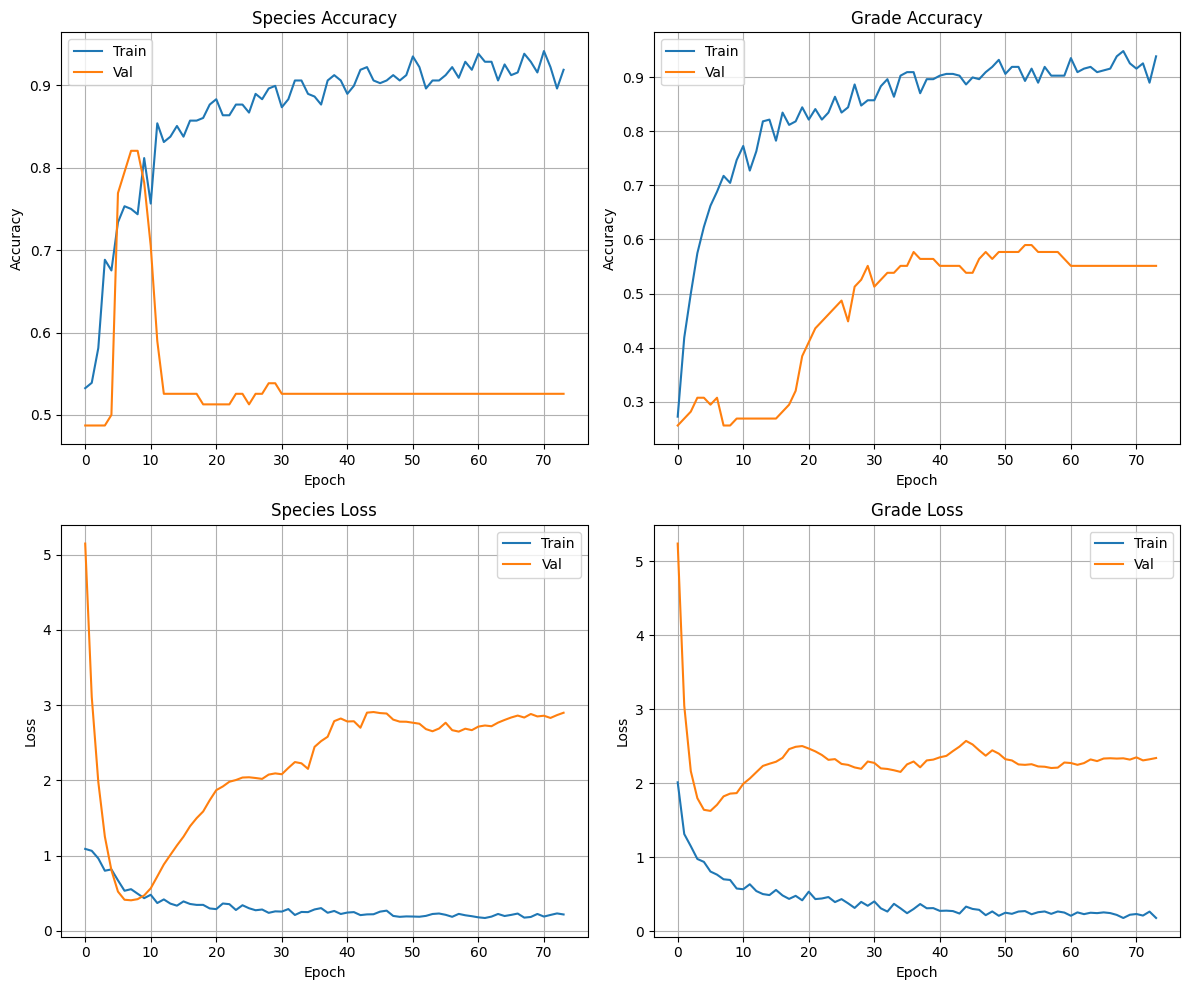

✅ Training history saved as 'training_history.png'

6️⃣ Evaluating...

📊 Model Evaluation
✅ Using best saved model

📈 Results:
  grade_output_accuracy: 0.5897
  grade_output_loss: 2.2197
  loss: 2.3750
  species_output_accuracy: 0.5256
  species_output_loss: 2.6469

📋 Species Classification Report:
              precision    recall  f1-score   support

        Tuna       1.00      0.03      0.05        38
     Makerel       0.52      1.00      0.68        40

    accuracy                           0.53        78
   macro avg       0.76      0.51      0.37        78
weighted avg       0.75      0.53      0.38        78


📋 Grade Classification Report:
              precision    recall  f1-score   support

           A       0.94      0.88      0.91        17
           B       1.00      0.27      0.42        41
           C       0.39      1.00      0.56        20

    accuracy                           0.59        78
   macro avg       0.78      0.72      0.63        78
weighted avg   

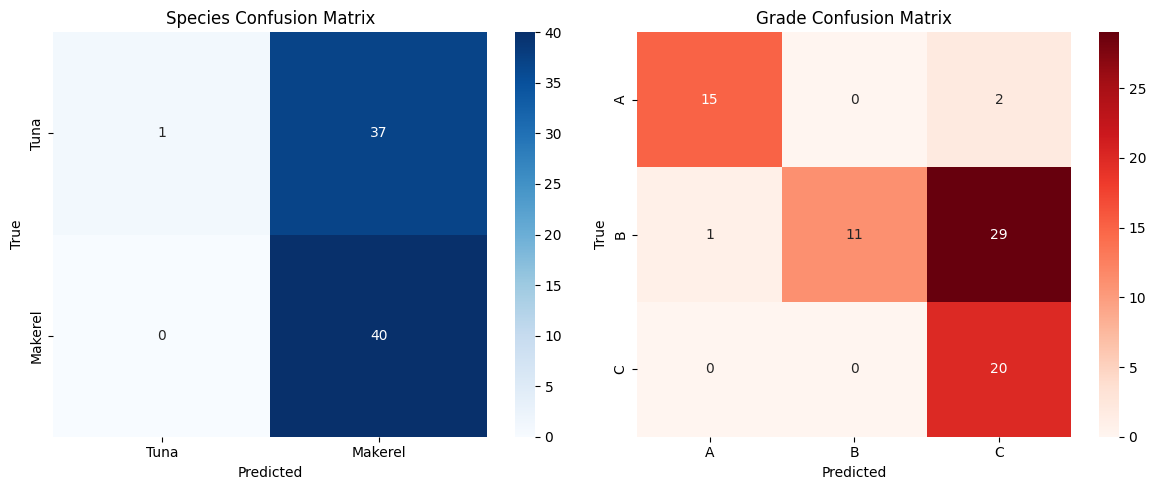

✅ Confusion matrices saved as 'simple_confusion_matrices.png'

7️⃣ Saving model...

✅ Model saved to: models/simple_fish_model.h5
✅ Metadata saved to 'models/model_metadata.json'

🎉 SYSTEM COMPLETED SUCCESSFULLY!

🧹 Memory cleanup completed!


In [178]:
# ============================================================================
# SECTION 9: EXECUTE THE SYSTEM
# ============================================================================
if __name__ == "__main__":
    print("\n" + "="*60)
    print("STARTING SIMPLE FISH QUALITY GRADING")
    print("="*60)
    
    # Clear any previous models to avoid conflicts
    if os.path.exists('models/simple_best_model.h5'):
        try:
            os.remove('models/simple_best_model.h5')
            print("Cleared previous best model")
        except:
            pass
    
    # Execute main function
    trainer, dataset_loader = main_simple()
    
    # Memory cleanup
    gc.collect()
    print("\n🧹 Memory cleanup completed!")

In [194]:
# ============================================================================
# SECTION 10: MODEL INFERENCE FOR SINGLE FISH PAIR
# ============================================================================
import os
import numpy as np
import cv2
import json
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

class FishQualityPredictor:
    """Class for predicting fish quality using trained model"""
    
    def __init__(self, model_path='models/simple_best_model.h5', 
                 metadata_path='models/model_metadata.json'):
        """
        Initialize the predictor with trained model and metadata
        
        Args:
            model_path: Path to saved model
            metadata_path: Path to model metadata
        """
        self.model_path = model_path
        self.metadata_path = metadata_path
        self.model = None
        self.metadata = None
        self.img_size = 128
        
        # Load model and metadata
        self._load_model_and_metadata()
        
    def _load_model_and_metadata(self):
        """Load trained model and metadata"""
        try:
            # Load metadata
            if os.path.exists(self.metadata_path):
                with open(self.metadata_path, 'r') as f:
                    self.metadata = json.load(f)
                self.img_size = self.metadata.get('img_size', 128)
                self.species_labels = self.metadata.get('species_labels', [])
                self.grade_labels = self.metadata.get('grade_labels', [])
                print("✅ Metadata loaded successfully")
            else:
                print("⚠️ Metadata file not found, using defaults")
                self.species_labels = ['Tuna', 'Makerel']
                self.grade_labels = ['A', 'B', 'C']
            
            # Load model
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                print(f"✅ Model loaded from {self.model_path}")
            else:
                print(f"❌ Model file not found at {self.model_path}")
                print("⚠️ Please train the model first or provide correct path")
                
        except Exception as e:
            print(f"❌ Error loading model/metadata: {e}")
    
    def preprocess_image(self, image_path):
        """
        Preprocess single image for prediction
        
        Args:
            image_path: Path to image file
            
        Returns:
            Preprocessed image array
        """
        # Read image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image from {image_path}")
        
        # Resize
        resized = cv2.resize(image, (self.img_size, self.img_size))
        
        # Convert BGR to RGB
        rgb_image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        
        # Normalize
        normalized = rgb_image.astype('float32') / 255.0
        
        # Standardize (ImageNet stats)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        normalized = (normalized - mean) / std
        
        return normalized
    
    def extract_features(self, left_img, right_img):
        """
        Extract features from image pair (same as training)
        """
        def extract_basic_color_features(image):
            if image is None:
                return np.zeros(24)
            
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            
            features = []
            
            # HSV statistics
            h, s, v = cv2.split(hsv)
            features.extend([np.mean(h), np.std(h), np.mean(s), np.std(s), np.mean(v), np.std(v)])
            
            # LAB statistics
            l, a, b = cv2.split(lab)
            features.extend([np.mean(l), np.std(l), np.mean(a), np.std(a), np.mean(b), np.std(b)])
            
            # RGB histograms
            hist_b = cv2.calcHist([image], [0], None, [4], [0, 256]).flatten()
            hist_g = cv2.calcHist([image], [1], None, [4], [0, 256]).flatten()
            hist_r = cv2.calcHist([image], [2], None, [4], [0, 256]).flatten()
            
            # Normalize
            hist_b = hist_b / (np.sum(hist_b) + 1e-10)
            hist_g = hist_g / (np.sum(hist_g) + 1e-10)
            hist_r = hist_r / (np.sum(hist_r) + 1e-10)
            
            features.extend(list(hist_b))
            features.extend(list(hist_g))
            features.extend(list(hist_r))
            
            return np.array(features)
        
        def extract_basic_quality_features(image):
            if image is None:
                return np.zeros(5)
            
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            features = []
            
            # Blood detection
            lower_red = np.array([0, 50, 50])
            upper_red = np.array([10, 255, 255])
            mask = cv2.inRange(hsv, lower_red, upper_red)
            blood_percentage = np.sum(mask > 0) / (mask.size + 1e-10)
            features.append(blood_percentage)
            
            # Brightness
            features.append(np.mean(gray))
            
            # Contrast
            contrast = np.std(gray) / (np.mean(gray) + 1e-10)
            features.append(contrast)
            
            # Edge density
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / (edges.size + 1e-10)
            features.append(edge_density)
            
            # Entropy
            hist = cv2.calcHist([gray], [0], None, [16], [0, 256])
            hist = hist / (np.sum(hist) + 1e-10)
            entropy = -np.sum(hist * np.log(hist + 1e-10))
            features.append(entropy)
            
            return np.array(features)
        
        # Extract features
        left_color = extract_basic_color_features(left_img)
        left_quality = extract_basic_quality_features(left_img)
        
        right_color = extract_basic_color_features(right_img)
        right_quality = extract_basic_quality_features(right_img)
        
        # Combine
        left_all = np.concatenate([left_color, left_quality])
        right_all = np.concatenate([right_color, right_quality])
        
        # Difference features
        diff_features = np.abs(left_all[:10] - right_all[:10])
        
        # Combined features (68 total)
        combined_features = np.concatenate([
            left_all,      # 29
            right_all,     # 29
            diff_features  # 10
        ])
        
        return combined_features
    
    def predict(self, left_image_path, right_image_path, show_images=True):
        """
        Predict species and grade for a fish pair
        
        Args:
            left_image_path: Path to left side image
            right_image_path: Path to right side image
            show_images: Whether to display images with predictions
            
        Returns:
            Dictionary with predictions and confidence scores
        """
        if self.model is None:
            raise ValueError("Model not loaded. Please check model path.")
        
        print(f"\n🔍 Analyzing fish pair:")
        print(f"  Left image: {os.path.basename(left_image_path)}")
        print(f"  Right image: {os.path.basename(right_image_path)}")
        
        # Read original images for feature extraction
        left_img_orig = cv2.imread(left_image_path)
        right_img_orig = cv2.imread(right_image_path)
        
        if left_img_orig is None:
            raise ValueError(f"Could not read left image: {left_image_path}")
        if right_img_orig is None:
            raise ValueError(f"Could not read right image: {right_image_path}")
        
        # Preprocess images for model
        left_img = self.preprocess_image(left_image_path)
        right_img = self.preprocess_image(right_image_path)
        
        # Extract features
        features = self.extract_features(left_img_orig, right_img_orig)
        
        # Reshape for model input
        left_img_input = np.expand_dims(left_img, axis=0)
        right_img_input = np.expand_dims(right_img, axis=0)
        features_input = np.expand_dims(features, axis=0)
        
        # Make prediction
        predictions = self.model.predict(
            [left_img_input, right_img_input, features_input],
            verbose=0
        )
        
        # Get species and grade predictions
        species_pred = predictions[0][0]  # First output: species
        grade_pred = predictions[1][0]    # Second output: grade
        
        # Get predicted class and confidence
        species_class = np.argmax(species_pred)
        grade_class = np.argmax(grade_pred)
        
        species_label = self.species_labels[species_class] if species_class < len(self.species_labels) else f"Class {species_class}"
        grade_label = self.grade_labels[grade_class] if grade_class < len(self.grade_labels) else f"Class {grade_class}"
        
        species_confidence = species_pred[species_class]
        grade_confidence = grade_pred[grade_class]
        
        # Create result dictionary
        result = {
            'species': {
                'label': species_label,
                'class': int(species_class),
                'confidence': float(species_confidence),
                'all_probabilities': species_pred.tolist()
            },
            'grade': {
                'label': grade_label,
                'class': int(grade_class),
                'confidence': float(grade_confidence),
                'all_probabilities': grade_pred.tolist()
            }
        }
        
        # Print results
        print("\n📊 Prediction Results:")
        print("="*40)
        print(f"Species: {species_label}")
        print(f"  Confidence: {species_confidence:.2%}")
        print(f"Grade: {grade_label}")
        print(f"  Confidence: {grade_confidence:.2%}")
        print("="*40)
        
        # Show images with predictions if requested
        if show_images:
            self._display_results(left_img_orig, right_img_orig, result, 
                                 left_image_path, right_image_path)
        
        return result
    
    def _display_results(self, left_img, right_img, result, left_path, right_path):
        """Display images with prediction results"""
        # Convert BGR to RGB for display
        left_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
        right_rgb = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Left image
        axes[0].imshow(left_rgb)
        axes[0].set_title(f'Left Side\n{os.path.basename(left_path)}')
        axes[0].axis('off')
        
        # Right image
        axes[1].imshow(right_rgb)
        axes[1].set_title(f'Right Side\n{os.path.basename(right_path)}')
        axes[1].axis('off')
        
        # Add prediction text
        prediction_text = (
            f"Predicted Species: {result['species']['label']}\n"
            f"Confidence: {result['species']['confidence']:.2%}\n\n"
            f"Predicted Grade: {result['grade']['label']}\n"
            f"Confidence: {result['grade']['confidence']:.2%}"
        )
        
        plt.figtext(0.5, 0.01, prediction_text, 
                   ha='center', fontsize=12, 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.suptitle('Fish Quality Prediction', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Display probability distributions
        self._plot_probability_distributions(result)
    
    def _plot_probability_distributions(self, result):
        """Plot probability distributions for classes"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Species probabilities
        species_probs = result['species']['all_probabilities']
        x_pos = np.arange(len(self.species_labels))
        
        axes[0].bar(x_pos, species_probs, color='skyblue', alpha=0.8)
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels(self.species_labels)
        axes[0].set_ylabel('Probability')
        axes[0].set_title('Species Probability Distribution')
        axes[0].set_ylim([0, 1])
        
        # Add value labels on bars
        for i, v in enumerate(species_probs):
            axes[0].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
        
        # Grade probabilities
        grade_probs = result['grade']['all_probabilities']
        x_pos = np.arange(len(self.grade_labels))
        
        bars = axes[1].bar(x_pos, grade_probs, color='lightcoral', alpha=0.8)
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(self.grade_labels)
        axes[1].set_ylabel('Probability')
        axes[1].set_title('Grade Probability Distribution')
        axes[1].set_ylim([0, 1])
        
        # Highlight predicted grade
        predicted_idx = result['grade']['class']
        if predicted_idx < len(bars):
            bars[predicted_idx].set_color('red')
            bars[predicted_idx].set_alpha(1.0)
        
        # Add value labels on bars
        for i, v in enumerate(grade_probs):
            axes[1].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

print("✅ Fish Quality Predictor class ready!")


✅ Fish Quality Predictor class ready!


In [196]:

# ============================================================================
# SECTION 11: TEST SINGLE FISH PAIR
# ============================================================================
def test_single_fish_pair():
    """Test the model on a single fish pair"""
    
    # Define your image paths
    left_image_path = r"D:\Hirusha\fish_data\train\makerel\grade_C\makerel_014_C_L.JPG"
    right_image_path = r"D:\Hirusha\fish_data\train\makerel\grade_C\makerel_014_C_R.JPG"
    
    print("="*60)
    print("🧪 TESTING SINGLE FISH PAIR")
    print("="*60)
    
    # Initialize predictor
    predictor = FishQualityPredictor()
    
    if predictor.model is None:
        print("❌ Model not available. Please train the model first.")
        return
    
    try:
        # Make prediction
        result = predictor.predict(left_image_path, right_image_path, show_images=True)
        
        # Save results to file
        with open('prediction_results.json', 'w') as f:
            json.dump(result, f, indent=4)
        print("\n✅ Results saved to 'prediction_results.json'")
        
        return result
        
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        import traceback
        traceback.print_exc()  # This will show the full error traceback
        return None

print("✅ Single fish testing function ready!")


✅ Single fish testing function ready!


In [198]:

# ============================================================================
# SECTION 12: SIMPLE TEST (NO VISUALIZATION)
# ============================================================================
def simple_test(left_image_path, right_image_path):
    """
    Simple test without visualization for quick results
    
    Args:
        left_image_path: Path to left image
        right_image_path: Path to right image
        
    Returns:
        Dictionary with prediction results
    """
    print("="*60)
    print("🧪 SIMPLE TEST (NO VISUALIZATION)")
    print("="*60)
    
    # Initialize predictor
    predictor = FishQualityPredictor()
    
    if predictor.model is None:
        print("❌ Model not available. Please train the model first.")
        return None
    
    try:
        # Make prediction without showing images
        result = predictor.predict(left_image_path, right_image_path, show_images=False)
        return result
        
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None

print("✅ Simple test function ready!")


✅ Simple test function ready!


In [200]:

# ============================================================================
# SECTION 13: QUICK TEST MULTIPLE IMAGES
# ============================================================================
def quick_test_images():
    """Quick test with multiple example images"""
    
    # Test multiple fish pairs
    test_cases = [
        {
            'left': r"D:\Hirusha\fish_data\train\makerel\grade_C\makerel_014_C_L.JPG",
            'right': r"D:\Hirusha\fish_data\train\makerel\grade_C\makerel_014_C_R.JPG",
            'expected_species': 'Makerel',
            'expected_grade': 'C'
        },
        # Add more test cases as needed
        # {
        #     'left': r"D:\Hirusha\fish_data\train\tuna\grade_A\tuna_001_A_L.JPG",
        #     'right': r"D:\Hirusha\fish_data\train\tuna\grade_A\tuna_001_A_R.JPG",
        #     'expected_species': 'Tuna',
        #     'expected_grade': 'A'
        # }
    ]
    
    print("="*60)
    print("🧪 QUICK TEST MULTIPLE IMAGES")
    print("="*60)
    
    predictor = FishQualityPredictor()
    
    if predictor.model is None:
        print("❌ Model not available.")
        return
    
    results_summary = []
    
    for i, test_case in enumerate(test_cases):
        print(f"\nTest Case {i+1}:")
        print(f"  Left: {os.path.basename(test_case['left'])}")
        print(f"  Right: {os.path.basename(test_case['right'])}")
        print(f"  Expected: {test_case['expected_species']} - Grade {test_case['expected_grade']}")
        
        try:
            result = predictor.predict(test_case['left'], test_case['right'], show_images=False)
            
            # Check if prediction matches expected
            species_correct = result['species']['label'] == test_case['expected_species']
            grade_correct = result['grade']['label'] == test_case['expected_grade']
            
            test_result = {
                'test_case': i+1,
                'left_image': os.path.basename(test_case['left']),
                'right_image': os.path.basename(test_case['right']),
                'predicted_species': result['species']['label'],
                'predicted_grade': result['grade']['label'],
                'species_confidence': result['species']['confidence'],
                'grade_confidence': result['grade']['confidence'],
                'species_correct': species_correct,
                'grade_correct': grade_correct,
                'all_correct': species_correct and grade_correct
            }
            
            results_summary.append(test_result)
            
            print(f"  Result: {result['species']['label']} - Grade {result['grade']['label']}")
            print(f"  Confidence: Species={result['species']['confidence']:.2%}, Grade={result['grade']['confidence']:.2%}")
            print(f"  ✓ Correct" if test_result['all_correct'] else "  ✗ Incorrect")
            
        except Exception as e:
            print(f"  ⚠️ Error: {e}")
            results_summary.append({
                'test_case': i+1,
                'error': str(e)
            })
    
    # Print summary
    print("\n" + "="*60)
    print("📊 TEST SUMMARY")
    print("="*60)
    
    if results_summary:
        correct_count = sum(1 for r in results_summary if r.get('all_correct', False))
        total_count = len([r for r in results_summary if 'all_correct' in r])
        
        print(f"\nTotal Tests: {total_count}")
        print(f"Correct Predictions: {correct_count}")
        print(f"Accuracy: {(correct_count/total_count)*100:.1f}%" if total_count > 0 else "N/A")
        
        # Save summary
        with open('test_summary.json', 'w') as f:
            json.dump(results_summary, f, indent=4)
        print("\n✅ Test summary saved to 'test_summary.json'")

print("✅ Quick test function ready!")


✅ Quick test function ready!



🧪 FISH QUALITY TESTING MODULE

1️⃣ Testing single fish pair with visualization...
🧪 TESTING SINGLE FISH PAIR
✅ Metadata loaded successfully
✅ Model loaded from models/simple_best_model.h5

🔍 Analyzing fish pair:
  Left image: makerel_014_C_L.JPG
  Right image: makerel_014_C_R.JPG

📊 Prediction Results:
Species: Makerel
  Confidence: 100.00%
Grade: C
  Confidence: 100.00%


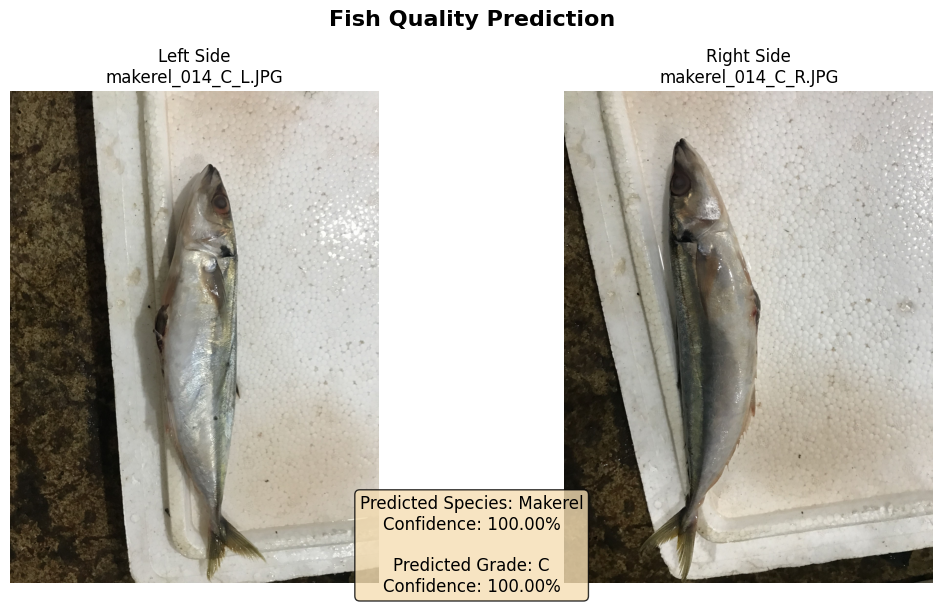

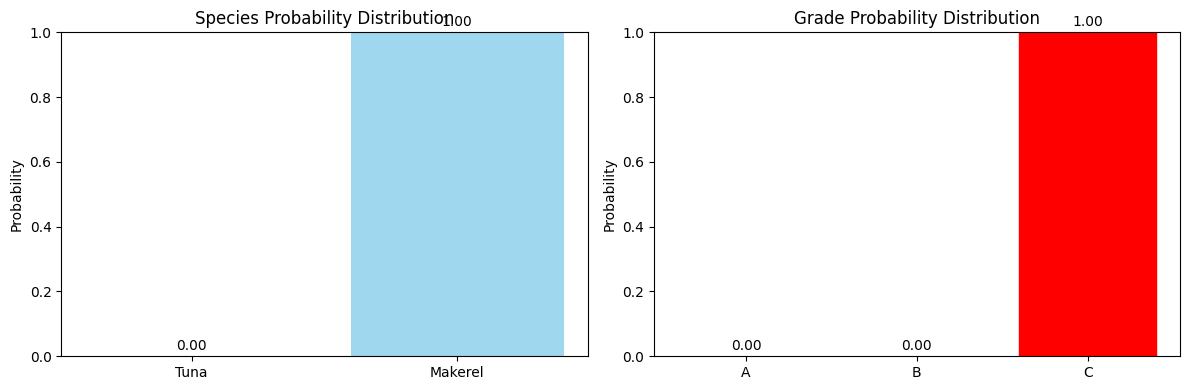


✅ Results saved to 'prediction_results.json'

✅ Testing completed!


In [202]:

# ============================================================================
# SECTION 14: EXECUTE TESTING
# ============================================================================
if __name__ == "__main__":
    print("\n" + "="*60)
    print("🧪 FISH QUALITY TESTING MODULE")
    print("="*60)
    
    # Option 1: Test single fish pair with visualization
    print("\n1️⃣ Testing single fish pair with visualization...")
    test_single_fish_pair()
    
    # Option 2: Quick test without visualization
    # print("\n2️⃣ Quick test without visualization...")
    # left_path = r"D:\Hirusha\fish_data\train\makerel\grade_C\makerel_014_C_L.JPG"
    # right_path = r"D:\Hirusha\fish_data\train\makerel\grade_C\makerel_014_C_R.JPG"
    # result = simple_test(left_path, right_path)
    # if result:
    #     print(f"\nQuick Result: {result['species']['label']} - Grade {result['grade']['label']}")
    
    # Option 3: Quick test multiple images
    # print("\n3️⃣ Quick test multiple images...")
    # quick_test_images()
    
    print("\n✅ Testing completed!")

🧪 TESTING SINGLE FISH PAIR
✅ Metadata loaded successfully
✅ Model loaded from models/simple_best_model.h5

🔍 Analyzing fish pair:
  Left image: makerel_014_C_L.JPG
  Right image: makerel_014_C_R.JPG

📊 Prediction Results:
Species: Makerel
  Confidence: 100.00%
Grade: C
  Confidence: 100.00%


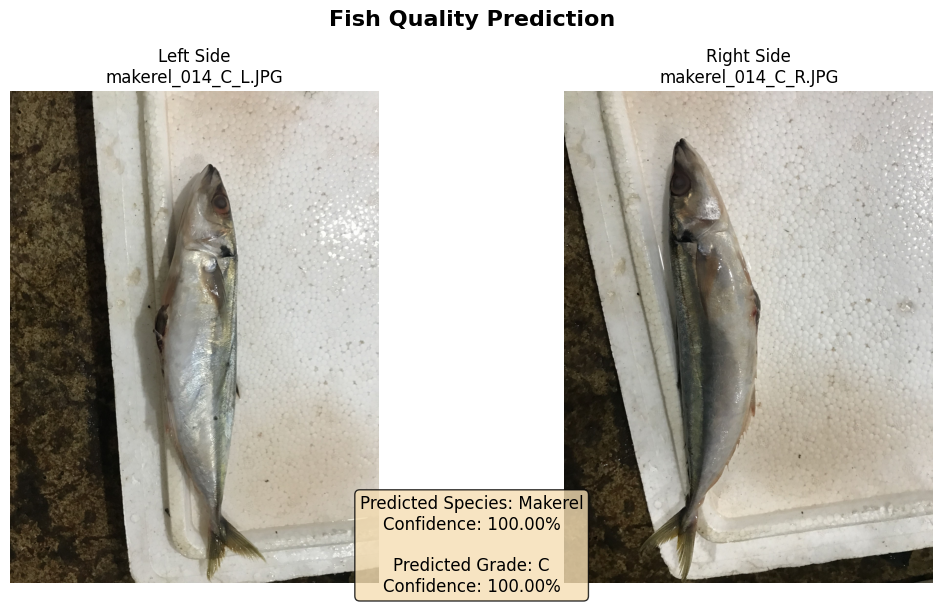

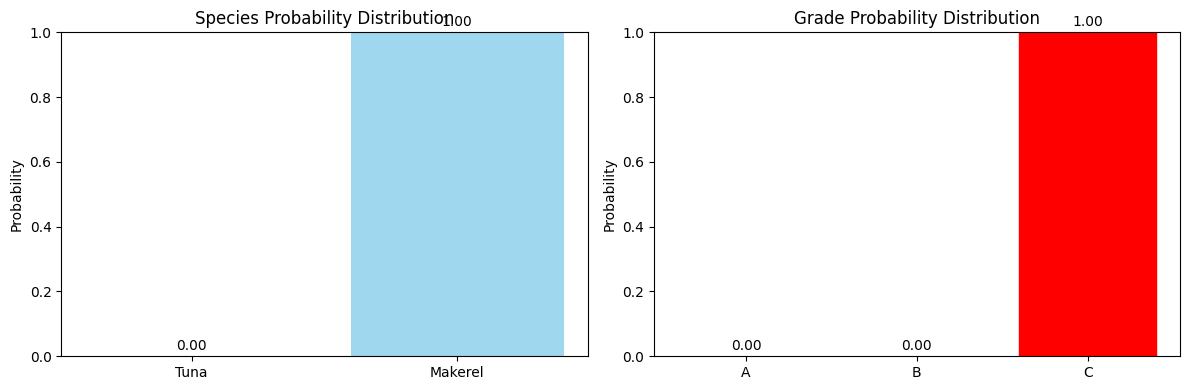


✅ Results saved to 'prediction_results.json'
🧪 SIMPLE TEST (NO VISUALIZATION)
✅ Metadata loaded successfully
✅ Model loaded from models/simple_best_model.h5

🔍 Analyzing fish pair:
  Left image: makerel_014_B_L.JPG
  Right image: makerel_014_B_R.JPG

📊 Prediction Results:
Species: Makerel
  Confidence: 100.00%
Grade: C
  Confidence: 98.43%


In [204]:
# Test with visualization
test_single_fish_pair()

# OR for quick testing without visualization:
left_path = r"D:\Hirusha\fish_data\train\makerel\grade_B\makerel_014_B_L.JPG"
right_path = r"D:\Hirusha\fish_data\train\makerel\grade_B\makerel_014_B_R.JPG"
result = simple_test(left_path, right_path)